In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [0]:
"""from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""      

'from google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n'

In [0]:
#datafraud = pd.read_csv("Fraud_Data.csv")
#datafraud.head(20)


In [0]:
#datapays = pd.read_csv("IpAddress_to_Country.csv")
#datapays.head(20)

1. Pour chacun des utilisateurs, déterminez le pays d'origine depuis son adresse IP

In [0]:
#list=datapays.values.tolist()
#def ip_country (arg=None):
#  for i in list:
#    if ((arg>=i[0]) & (arg<=i[1])):
#      return i[2]
#  return "unknown"

In [0]:
#datafraud["country"] = datafraud.ip_address.apply(lambda x : ip_country(x))
#datafraud.head()

In [0]:
#datafraud['country'] = (datafraud.ip_address.apply(lambda x: datapays.query('lower_bound_ip_address <= @x <= upper_bound_ip_address').index.values).apply(lambda x: x[0] if len(x) else -1)).apply(lambda x: datapays.country[x] if x != -1 else x)

In [0]:
dataset = pd.read_csv("fraud_data_country.csv")
dataset.head(20)

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,unknown
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
5,5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada
6,6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,unknown
7,7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,United States
8,8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,China
9,9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,United States


In [0]:
#dataset = dataset.sample(10000)

In [0]:
from dateutil import parser
dataset.purchase_time = dataset.purchase_time.apply(lambda x :   parser.parse(x))
dataset.signup_time =dataset.signup_time.apply(lambda x :   parser.parse(x))

In [0]:
dataset["delay"] = (dataset.purchase_time - dataset.signup_time).dt.total_seconds()

In [0]:
dataset['purchase_day_of_week'] = dataset['purchase_time'].dt.day_name()
dataset['signup day_of_week'] = dataset['signup_time'].dt.day_name()

dataset['purchase_month'] = dataset['purchase_time'].dt.month_name()


dataset['purchase_moment_t'] = pd.to_datetime(dataset.purchase_time, format='%H:%M')
a = dataset.assign(session=pd.cut(dataset.purchase_moment_t.dt.hour,[0,6,12,18,24],labels=['Night','Morning','Afternoon','Evening']))
dataset['purchase_moment'] = a['session']

In [0]:
# On supprime les features qui nous paraissent inutiles à l'entrainement de nos futurs modèles
dataset = dataset.drop(['signup_time','purchase_time','Unnamed: 0', 'user_id','device_id','ip_address','country'], axis=1)
dataset.head()

,purchase_value,source,browser,sex,age,class,delay,purchase_day_of_week,signup day_of_week,purchase_month,purchase_moment_t,purchase_moment
0,34,SEO,Chrome,M,39,0,4506682.0,Saturday,Tuesday,April,2015-04-18 02:47:11,Night
1,16,Ads,Chrome,F,53,0,17944.0,Monday,Sunday,June,2015-06-08 01:38:54,Night
2,15,SEO,Opera,M,53,1,1.0,Thursday,Thursday,January,2015-01-01 18:52:45,Afternoon
3,44,SEO,Safari,M,41,0,492085.0,Monday,Tuesday,May,2015-05-04 13:54:50,Afternoon
4,39,Ads,Safari,M,45,0,4361461.0,Wednesday,Tuesday,September,2015-09-09 18:40:53,Afternoon


In [0]:
dataset.describe()

,purchase_value,age,class,delay
count,151112.000000,151112.000000,151112.000000,1.511120e+05
mean,36.935372,33.140704,0.093646,4.932029e+06
std,18.322762,8.617733,0.291336,3.126263e+06
min,9.000000,18.000000,0.000000,1.000000e+00
25%,22.000000,27.000000,0.000000,2.186754e+06
50%,35.000000,33.000000,0.000000,4.926346e+06
75%,49.000000,39.000000,0.000000,7.644525e+06
max,154.000000,76.000000,1.000000,1.036797e+07


Pas de valeurs abérrantes à proprement dit

In [0]:
# On va créer deux nouvelles variables en classes pour l'âge et le purchase_value
from sklearn.preprocessing import KBinsDiscretizer
kb = KBinsDiscretizer(n_bins=10, strategy='quantile', encode = "ordinal")
dataset['tr_age'] = kb.fit_transform(dataset[['age']])
dataset['tr_purchase_value'] = kb.fit_transform(dataset[['purchase_value']])

dataset.head()

,purchase_value,source,browser,sex,age,class,delay,purchase_day_of_week,signup day_of_week,purchase_month,purchase_moment_t,purchase_moment,tr_age,tr_purchase_value
0,34,SEO,Chrome,M,39,0,4506682.0,Saturday,Tuesday,April,2015-04-18 02:47:11,Night,7.0,4.0
1,16,Ads,Chrome,F,53,0,17944.0,Monday,Sunday,June,2015-06-08 01:38:54,Night,9.0,1.0
2,15,SEO,Opera,M,53,1,1.0,Thursday,Thursday,January,2015-01-01 18:52:45,Afternoon,9.0,1.0
3,44,SEO,Safari,M,41,0,492085.0,Monday,Tuesday,May,2015-05-04 13:54:50,Afternoon,8.0,6.0
4,39,Ads,Safari,M,45,0,4361461.0,Wednesday,Tuesday,September,2015-09-09 18:40:53,Afternoon,9.0,5.0


In [0]:
# On crée de npouvelles variables binaires avec les variables catégorielles
dataset = pd.get_dummies(dataset, drop_first=True)
dataset.head()

,purchase_value,age,class,delay,purchase_moment_t,tr_age,tr_purchase_value,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,purchase_day_of_week_Monday,purchase_day_of_week_Saturday,purchase_day_of_week_Sunday,purchase_day_of_week_Thursday,purchase_day_of_week_Tuesday,purchase_day_of_week_Wednesday,signup day_of_week_Monday,signup day_of_week_Saturday,signup day_of_week_Sunday,signup day_of_week_Thursday,signup day_of_week_Tuesday,signup day_of_week_Wednesday,purchase_month_August,purchase_month_December,purchase_month_February,purchase_month_January,purchase_month_July,purchase_month_June,purchase_month_March,purchase_month_May,purchase_month_November,purchase_month_October,purchase_month_September,purchase_moment_Morning,purchase_moment_Afternoon,purchase_moment_Evening
0,34,39,0,4506682.0,2015-04-18 02:47:11,7.0,4.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16,53,0,17944.0,2015-06-08 01:38:54,9.0,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,15,53,1,1.0,2015-01-01 18:52:45,9.0,1.0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,44,41,0,492085.0,2015-05-04 13:54:50,8.0,6.0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,39,45,0,4361461.0,2015-09-09 18:40:53,9.0,5.0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [0]:
dataset = dataset.drop(['tr_age','tr_purchase_value','purchase_moment_t'], axis=1)
dataset.describe()

,purchase_value,age,class,delay,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,purchase_day_of_week_Monday,purchase_day_of_week_Saturday,purchase_day_of_week_Sunday,purchase_day_of_week_Thursday,purchase_day_of_week_Tuesday,purchase_day_of_week_Wednesday,signup day_of_week_Monday,signup day_of_week_Saturday,signup day_of_week_Sunday,signup day_of_week_Thursday,signup day_of_week_Tuesday,signup day_of_week_Wednesday,purchase_month_August,purchase_month_December,purchase_month_February,purchase_month_January,purchase_month_July,purchase_month_June,purchase_month_March,purchase_month_May,purchase_month_November,purchase_month_October,purchase_month_September,purchase_moment_Morning,purchase_moment_Afternoon,purchase_moment_Evening
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.00000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000
mean,36.935372,33.140704,0.093646,4.932029e+06,0.202605,0.401126,0.162859,0.243045,0.024326,0.163237,0.584288,0.143675,0.143258,0.145687,0.142848,0.141048,0.141061,0.144734,0.144012,0.146295,0.144793,0.137726,0.136217,0.123498,0.003832,0.042677,0.066818,0.12909,0.125126,0.080007,0.128143,0.031387,0.064952,0.094943,0.250251,0.251754,0.207952
std,18.322762,8.617733,0.291336,3.126263e+06,0.401942,0.490128,0.369239,0.428923,0.154061,0.369583,0.492846,0.350761,0.350337,0.352793,0.349919,0.348072,0.348086,0.351833,0.351103,0.353403,0.351893,0.344613,0.343020,0.329009,0.061781,0.202128,0.249707,0.33530,0.330863,0.271305,0.334250,0.174363,0.246442,0.293137,0.433159,0.434022,0.405843
min,9.000000,18.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,27.000000,0.000000,2.186754e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,35.000000,33.000000,0.000000,4.926346e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49.000000,39.000000,0.000000,7.644525e+06,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,154.000000,76.000000,1.000000,1.036797e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
# On isole nos features du label
X = dataset.iloc[:, dataset.columns!="class"]
y = dataset.loc[:,"class"]

In [0]:
# On splitte les observations de notre dataset en données pour l'entrainement et pour le test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, stratify=y)
X_train.head()

,purchase_value,age,delay,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,purchase_day_of_week_Monday,purchase_day_of_week_Saturday,purchase_day_of_week_Sunday,purchase_day_of_week_Thursday,purchase_day_of_week_Tuesday,purchase_day_of_week_Wednesday,signup day_of_week_Monday,signup day_of_week_Saturday,signup day_of_week_Sunday,signup day_of_week_Thursday,signup day_of_week_Tuesday,signup day_of_week_Wednesday,purchase_month_August,purchase_month_December,purchase_month_February,purchase_month_January,purchase_month_July,purchase_month_June,purchase_month_March,purchase_month_May,purchase_month_November,purchase_month_October,purchase_month_September,purchase_moment_Morning,purchase_moment_Afternoon,purchase_moment_Evening
61049,42,31,5681411.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
141787,38,32,3918624.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
84407,12,36,3951945.0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
115800,12,19,135523.0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
61857,41,28,1354843.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [0]:
# On normalise nos données
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train = pd.DataFrame(sc_x.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(sc_x.transform(X_test), columns=X_train.columns)

In [0]:
X_train.head()

,purchase_value,age,delay,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,purchase_day_of_week_Monday,purchase_day_of_week_Saturday,purchase_day_of_week_Sunday,purchase_day_of_week_Thursday,purchase_day_of_week_Tuesday,purchase_day_of_week_Wednesday,signup day_of_week_Monday,signup day_of_week_Saturday,signup day_of_week_Sunday,signup day_of_week_Thursday,signup day_of_week_Tuesday,signup day_of_week_Wednesday,purchase_month_August,purchase_month_December,purchase_month_February,purchase_month_January,purchase_month_July,purchase_month_June,purchase_month_March,purchase_month_May,purchase_month_November,purchase_month_October,purchase_month_September,purchase_moment_Morning,purchase_moment_Afternoon,purchase_moment_Evening
0,0.272747,-0.248771,0.237076,-0.504861,-0.818360,-0.440627,-0.565523,-0.157738,-0.442171,-1.184210,2.444786,-0.408545,-0.413856,-0.407931,-0.406590,-0.405927,-0.411644,-0.409459,-0.415171,-0.410387,-0.400905,-0.398598,-0.375441,-0.062379,-0.211571,-0.267142,-0.385454,-0.377503,-0.294045,-0.382764,-0.180401,-0.26316,3.085440,-0.578435,-0.581375,-0.511547
1,0.054621,-0.132895,-0.326584,-0.504861,-0.818360,-0.440627,-0.565523,-0.157738,-0.442171,0.844445,-0.409034,-0.408545,-0.413856,-0.407931,-0.406590,2.463500,-0.411644,2.442248,-0.415171,-0.410387,-0.400905,-0.398598,2.663537,-0.062379,-0.211571,-0.267142,-0.385454,-0.377503,-0.294045,-0.382764,-0.180401,-0.26316,-0.324103,-0.578435,-0.581375,-0.511547
2,-1.363201,0.330606,-0.315930,-0.504861,1.221956,-0.440627,-0.565523,-0.157738,2.261568,0.844445,-0.409034,-0.408545,-0.413856,2.451396,-0.406590,-0.405927,-0.411644,-0.409459,2.408645,-0.410387,-0.400905,-0.398598,-0.375441,-0.062379,-0.211571,-0.267142,-0.385454,2.648986,-0.294045,-0.382764,-0.180401,-0.26316,-0.324103,-0.578435,-0.581375,-0.511547
3,-1.363201,-1.639274,-1.536250,-0.504861,1.221956,-0.440627,1.768274,-0.157738,-0.442171,0.844445,-0.409034,-0.408545,-0.413856,-0.407931,2.459481,-0.405927,2.429283,-0.409459,-0.415171,-0.410387,-0.400905,-0.398598,-0.375441,-0.062379,-0.211571,-0.267142,2.594343,-0.377503,-0.294045,-0.382764,-0.180401,-0.26316,-0.324103,-0.578435,-0.581375,1.954855
4,0.218216,-0.596397,-1.146366,-0.504861,1.221956,-0.440627,-0.565523,-0.157738,-0.442171,-1.184210,-0.409034,-0.408545,-0.413856,-0.407931,2.459481,-0.405927,-0.411644,-0.409459,2.408645,-0.410387,-0.400905,-0.398598,-0.375441,-0.062379,4.726547,-0.267142,-0.385454,-0.377503,-0.294045,-0.382764,-0.180401,-0.26316,-0.324103,1.728804,-0.581375,-0.511547


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
classifier = RandomForestClassifier(max_depth=7, random_state=42,class_weight='balanced')
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + ':' + str(accuracy_score(y_test, y_pred)))

[[41087     2]
 [ 1982  2263]]
Accuracy:0.9562359377067984


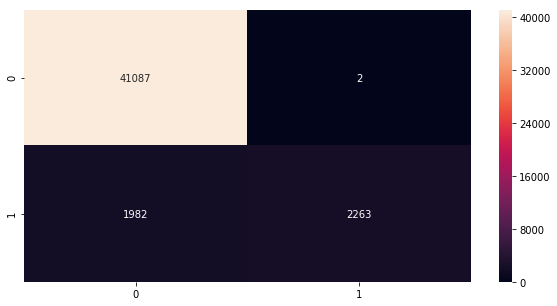

In [0]:
plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='d')


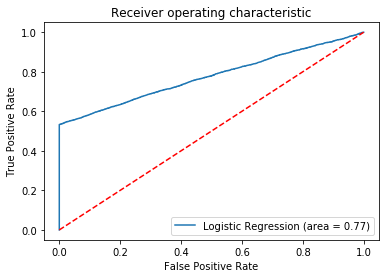

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

On a détecté (prédit) à 77% les cas de fraude

In [0]:
X_test.head()

,purchase_value,age,delay,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,purchase_day_of_week_Monday,purchase_day_of_week_Saturday,purchase_day_of_week_Sunday,purchase_day_of_week_Thursday,purchase_day_of_week_Tuesday,purchase_day_of_week_Wednesday,signup day_of_week_Monday,signup day_of_week_Saturday,signup day_of_week_Sunday,signup day_of_week_Thursday,signup day_of_week_Tuesday,signup day_of_week_Wednesday,purchase_month_August,purchase_month_December,purchase_month_February,purchase_month_January,purchase_month_July,purchase_month_June,purchase_month_March,purchase_month_May,purchase_month_November,purchase_month_October,purchase_month_September,purchase_moment_Morning,purchase_moment_Afternoon,purchase_moment_Evening
0,0.709000,-0.712272,-1.244734,-0.504861,-0.818360,-0.440627,-0.565523,-0.157738,-0.442171,0.844445,-0.409034,2.447708,-0.413856,-0.407931,-0.40659,-0.405927,2.429283,-0.409459,-0.415171,-0.410387,-0.400905,-0.398598,-0.375441,-0.062379,-0.211571,-0.267142,-0.385454,2.648986,-0.294045,-0.382764,-0.180401,-0.26316,-0.324103,-0.578435,-0.581375,-0.511547
1,1.254316,1.141733,-0.121528,-0.504861,1.221956,-0.440627,-0.565523,-0.157738,-0.442171,0.844445,2.444786,-0.408545,-0.413856,-0.407931,-0.40659,-0.405927,-0.411644,-0.409459,-0.415171,2.436725,-0.400905,-0.398598,-0.375441,-0.062379,-0.211571,-0.267142,-0.385454,-0.377503,-0.294045,2.612576,-0.180401,-0.26316,-0.324103,1.728804,-0.581375,-0.511547
2,-0.708822,-0.712272,-0.450591,-0.504861,1.221956,-0.440627,-0.565523,-0.157738,-0.442171,-1.184210,-0.409034,-0.408545,2.416300,-0.407931,-0.40659,-0.405927,2.429283,-0.409459,-0.415171,-0.410387,-0.400905,-0.398598,-0.375441,-0.062379,-0.211571,-0.267142,-0.385454,-0.377503,3.400837,-0.382764,-0.180401,-0.26316,-0.324103,-0.578435,-0.581375,-0.511547
3,-0.163506,0.214730,-1.508713,-0.504861,-0.818360,-0.440627,-0.565523,-0.157738,-0.442171,0.844445,-0.409034,-0.408545,-0.413856,-0.407931,-0.40659,-0.405927,-0.411644,-0.409459,-0.415171,-0.410387,2.494358,-0.398598,-0.375441,-0.062379,4.726547,-0.267142,-0.385454,-0.377503,-0.294045,-0.382764,-0.180401,-0.26316,-0.324103,-0.578435,-0.581375,-0.511547
4,0.545405,-1.291648,-0.190561,-0.504861,1.221956,2.269493,-0.565523,-0.157738,-0.442171,0.844445,-0.409034,-0.408545,-0.413856,2.451396,-0.40659,-0.405927,-0.411644,-0.409459,-0.415171,-0.410387,-0.400905,2.508790,-0.375441,-0.062379,-0.211571,-0.267142,-0.385454,-0.377503,-0.294045,-0.382764,-0.180401,-0.26316,-0.324103,-0.578435,-0.581375,1.954855


In [0]:
from sklearn.model_selection import cross_val_score

forest_score = cross_val_score(classifier, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse = np.sqrt(-forest_score)


In [0]:
"""
%%time
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

param_dist = {"n_estimators": np.arange(44, 46,1),
                "max_features": np.arange(8, 12,1)
             }

forest = RandomForestClassifier()
grid = GridSearchCV(forest, param_dist, cv=5, scoring="neg_mean_squared_error")
grid.fit(X_train, y_train)
"""

'\n%%time\nfrom sklearn.model_selection import GridSearchCV\nfrom scipy.stats import randint\n\nparam_dist = {"n_estimators": np.arange(44, 46,1),\n                "max_features": np.arange(8, 12,1)\n             }\n\nforest = RandomForestClassifier()\ngrid = GridSearchCV(forest, param_dist, cv=5, scoring="neg_mean_squared_error")\ngrid.fit(X_train, y_train)\n'

In [0]:
#grid.best_params_

In [0]:
#grid.best_estimator_.score(X_test, y_test)

In [0]:
classifier = RandomForestClassifier(n_estimators=44,max_features=10, random_state=42,class_weight='balanced')
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [0]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + ':' + str(accuracy_score(y_test, y_pred)))

[[41088     1]
 [ 1982  2263]]
Accuracy:0.9562579962059381


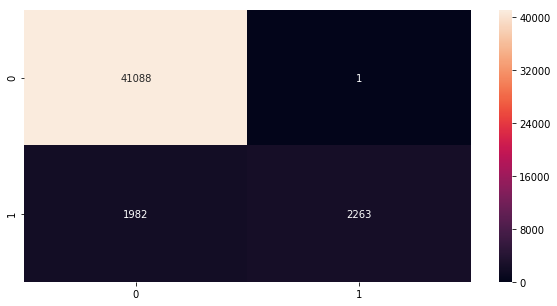

In [0]:
plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='d')


FN (ici 1982) : on a prédit qu'il n'allait pas y avoir de fraude alors qu'en réalité, il n'y en a eu une

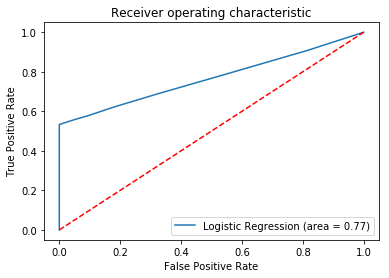

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()